In [1]:
from typing import List, Callable, Union, Any, TypeVar, Tuple
# from torch import tensor as Tensor
Tensor = TypeVar('torch.tensor')
import torch
from torch import nn
from abc import abstractmethod
from torch.nn import functional as F
import torchvision.utils as vutils

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import autograd
import matplotlib.image as mgimg
from matplotlib import animation
from IPython.display import HTML
import matplotlib
from tqdm.notebook import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.metrics import accuracy_score
from torch.utils.data.sampler import BatchSampler
from torch.utils.data import DataLoader
matplotlib.rcParams['animation.embed_limit'] = 2**128

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

seed = 1234
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

cuda


In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
!unzip "/content/drive/MyDrive/Courses/PML/img_align_celeba.zip" -d ./celeba/
!rm -r "/content/celeba/__MACOSX"

Streaming output truncated to the last 5000 lines.
  inflating: ./celeba/img_align_celeba/170645.jpg  
  inflating: ./celeba/__MACOSX/img_align_celeba/._170645.jpg  
  inflating: ./celeba/img_align_celeba/074351.jpg  
  inflating: ./celeba/__MACOSX/img_align_celeba/._074351.jpg  
  inflating: ./celeba/img_align_celeba/108926.jpg  
  inflating: ./celeba/__MACOSX/img_align_celeba/._108926.jpg  
  inflating: ./celeba/img_align_celeba/136610.jpg  
  inflating: ./celeba/__MACOSX/img_align_celeba/._136610.jpg  
  inflating: ./celeba/img_align_celeba/120072.jpg  
  inflating: ./celeba/__MACOSX/img_align_celeba/._120072.jpg  
  inflating: ./celeba/img_align_celeba/062533.jpg  
  inflating: ./celeba/__MACOSX/img_align_celeba/._062533.jpg  
  inflating: ./celeba/img_align_celeba/166027.jpg  
  inflating: ./celeba/__MACOSX/img_align_celeba/._166027.jpg  
  inflating: ./celeba/img_align_celeba/024566.jpg  
  inflating: ./celeba/__MACOSX/img_align_celeba/._024566.jpg  
  inflating: ./celeba/img_ali

In [5]:
class BaseVAE(nn.Module):
    
    def __init__(self) -> None:
        super(BaseVAE, self).__init__()

    def encode(self, input: Tensor) -> List[Tensor]:
        raise NotImplementedError

    def decode(self, input: Tensor) -> Any:
        raise NotImplementedError

    def sample(self, batch_size:int, current_device: int, **kwargs) -> Tensor:
        raise RuntimeWarning()

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        raise NotImplementedError

    @abstractmethod
    def forward(self, *inputs: Tensor) -> Tensor:
        pass

    @abstractmethod
    def loss_function(self, *inputs: Any, **kwargs) -> Tensor:
        pass

In [6]:
class VanillaVAE(BaseVAE):


    def __init__(self,
                 in_channels: int,
                 latent_dim: int,
                 hidden_dims: List = None,
                 **kwargs) -> None:
        super(VanillaVAE, self).__init__()

        self.latent_dim = latent_dim

        modules = []
        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256, 512]

        # Build Encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1]*4, latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1]*4, latent_dim)


        # Build Decoder
        modules = []

        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1] * 4)

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride = 2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )



        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            nn.ConvTranspose2d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=1,
                                               output_padding=1),
                            nn.BatchNorm2d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv2d(hidden_dims[-1], out_channels= 3,
                                      kernel_size= 3, padding= 1),
                            nn.Tanh())

    def encode(self, input: Tensor) -> List[Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return [mu, log_var]

    def decode(self, z: Tensor) -> Tensor:
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        result = self.decoder_input(z)
        result = result.view(-1, 512, 2, 2)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input: Tensor, **kwargs) -> List[Tensor]:
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        return  [self.decode(z), input, mu, log_var]

    def loss_function(self,
                      *args,
                      **kwargs) -> dict:
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]

        kld_weight = kwargs['M_N'] # Account for the minibatch samples from the dataset
        recons_loss =F.mse_loss(recons, input)


        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

        loss = recons_loss + kld_weight * kld_loss
        return {'loss': loss, 'Reconstruction_Loss':recons_loss, 'KLD':-kld_loss}

    def sample(self,
               num_samples:int,
               current_device: int, **kwargs) -> Tensor:
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        z = torch.randn(num_samples,
                        self.latent_dim)

        z = z.to(current_device)

        samples = self.decode(z)
        return samples

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """

        return self.forward(x)[0]

In [7]:
dataroot = "./celeba"
image_size = 64
batch_size = 2048
dataset = torchvision.datasets.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                            #    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

# # Plot some training images
# real_batch = next(iter(dataloader))
# plt.figure(figsize=(8,8))
# plt.axis("off")
# plt.title("Training Images")
# plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [8]:
torch.manual_seed(2990)
net = VanillaVAE(in_channels=3, latent_dim=256)
net.to(device)

VanillaVAE(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (4): Se

In [9]:
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
criterion = net.loss_function

In [10]:
train_loss = []
train_rec_loss = []
train_kld_loss = []
images = []

In [18]:
num_epochs = 10
start_epoch = 35

In [12]:
model_save_pth = "/content/drive/MyDrive/Courses/PML/VAE.pt"
# load model weights
net.load_state_dict(torch.load(model_save_pth))

<All keys matched successfully>

In [19]:
for epoch in range(start_epoch, start_epoch+num_epochs):  # loop over the dataset multiple times
    # set model for training
    net.train()

    for data in tqdm(dataloader, desc=f'epoch {epoch}/{start_epoch+num_epochs-1}'):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = F.one_hot(labels.to(device)).float()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        outputs = net(inputs)

        #compute loss
        losses = criterion(*outputs,  M_N = batch_size/len(dataset))
        loss = losses['loss']
        rec_loss = losses['Reconstruction_Loss']
        kld_loss = losses['KLD']

        # backward + optimize
        loss.backward()
        optimizer.step()

        # save losses
        train_loss.append(loss.item())
        train_rec_loss.append(rec_loss.item())
        train_kld_loss.append(kld_loss.item())

    torch.save(net.state_dict(), model_save_pth)


    # set model for evaluation
    # net.eval()
    # with torch.no_grad():
    #     Z_train, Y_train = get_latent_space(net, plotloader)
    #     images.append(plot_latent_space(net, Z_train, Y_train, epoch))

    # save model after each epoch
    # torch.save(net.state_dict(), model_save_pth+f"{epoch}.pt")

print('Finished Training')

epoch 35/44:   0%|          | 0/99 [00:00<?, ?it/s]

epoch 36/44:   0%|          | 0/99 [00:00<?, ?it/s]

epoch 37/44:   0%|          | 0/99 [00:00<?, ?it/s]

epoch 38/44:   0%|          | 0/99 [00:00<?, ?it/s]

epoch 39/44:   0%|          | 0/99 [00:00<?, ?it/s]

epoch 40/44:   0%|          | 0/99 [00:00<?, ?it/s]

epoch 41/44:   0%|          | 0/99 [00:00<?, ?it/s]

epoch 42/44:   0%|          | 0/99 [00:00<?, ?it/s]

epoch 43/44:   0%|          | 0/99 [00:00<?, ?it/s]

epoch 44/44:   0%|          | 0/99 [00:00<?, ?it/s]

Finished Training


In [20]:
 num_epochs = 10

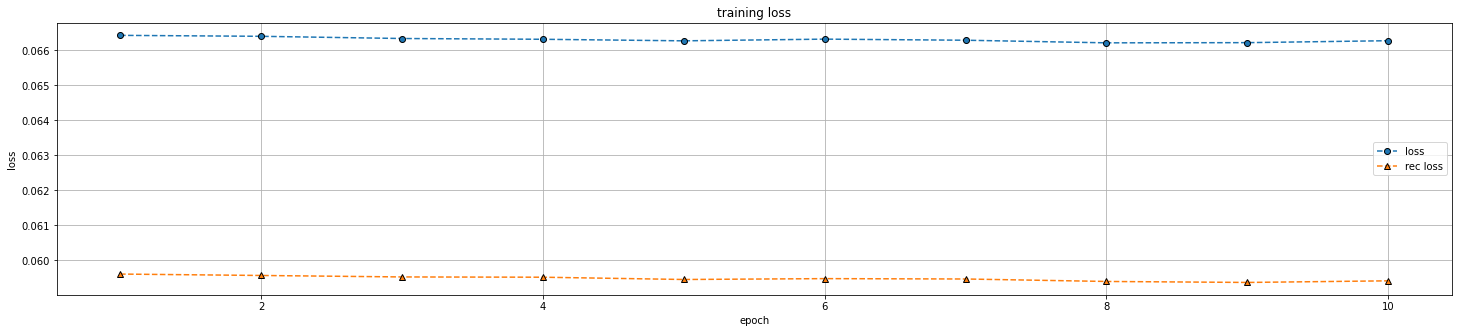

In [21]:
trainloader = dataloader
plt.figure(figsize=(25, 5))
y = [np.mean(train_loss[i:i+len(trainloader)]) for i in range(0, num_epochs*len(trainloader), len(trainloader))]
x = np.linspace(1, num_epochs, num_epochs)
plt.plot(x, y, label='loss', marker='o', linestyle='--', markeredgecolor='black')
# plt.title('training loss)
# plt.xlabel('epoch')
# plt.ylabel('loss')
# plt.grid()
# plt.legend()

# plt.figure(figsize=(25, 5))
y = [np.mean(train_rec_loss[i:i+len(trainloader)]) for i in range(0, num_epochs*len(trainloader), len(trainloader))]
x = np.linspace(1, num_epochs, num_epochs)
plt.plot(x, y, label='rec loss', marker='^', linestyle='--', markeredgecolor='black')
# plt.title('training loss')
# plt.xlabel('epoch')
# plt.ylabel('loss')
# plt.grid()
# plt.legend()


# plt.figure(figsize=(25, 5))
# y = [np.mean(train_kld_loss[i:i+len(trainloader)])*-1 for i in range(0, num_epochs*len(trainloader), len(trainloader))]
# x = np.linspace(1, num_epochs, num_epochs)
# plt.plot(x, y, label='kld loss', marker='*', linestyle='--', markeredgecolor='black')

plt.title('training loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()
plt.legend()

In [22]:
from torchvision.utils import make_grid

In [23]:
def plot_images_grid(x: torch.tensor, export_img='temp_grid.png', title: str = '', nrow=8, padding=2, normalize=False, pad_value=0):
    """Plot 4D Tensor of images of shape (B x C x H x W) as a grid."""
    plt.figure(figsize=(7, 7))
    grid = make_grid(x, nrow=nrow, padding=padding, normalize=normalize, pad_value=pad_value)
    npgrid = grid.cpu().numpy()

    plt.imshow(np.transpose(npgrid, (1, 2, 0)), interpolation='nearest')

    ax = plt.gca()
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    if not (title == ''):
        plt.title(title)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


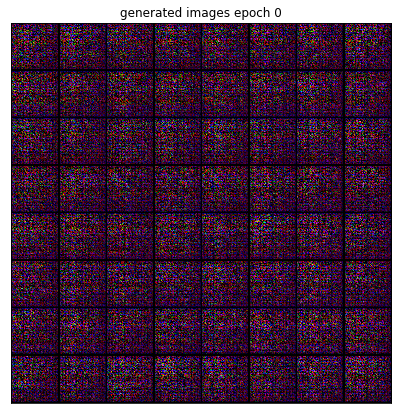

In [ ]:
plot_images_grid(net.sample(64, device), title='generated images epoch 0')

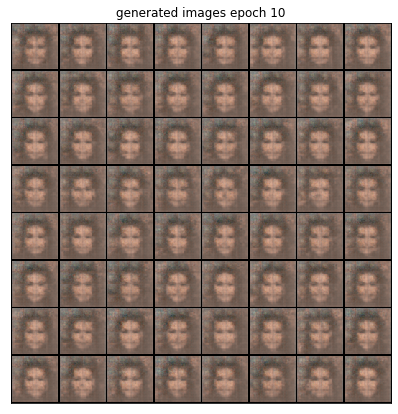

In [ ]:
plot_images_grid(net.sample(64, device), title='generated images epoch 10')

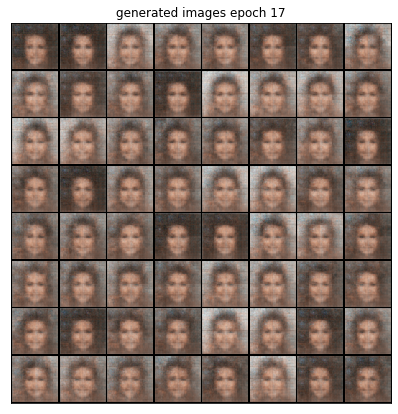

In [12]:
plot_images_grid(net.sample(64, device), title='generated images epoch 17')

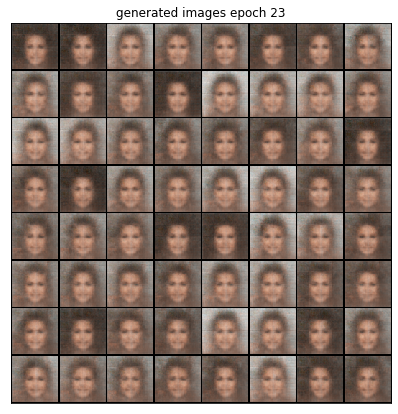

In [16]:
plot_images_grid(net.sample(64, device), title='generated images epoch 23')

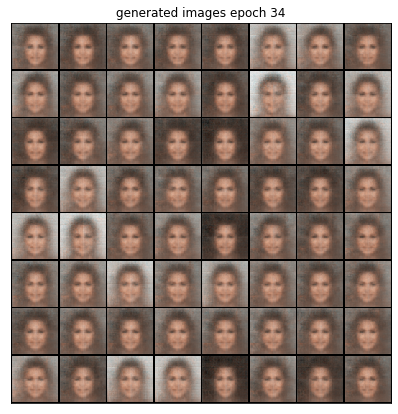

In [17]:
plot_images_grid(net.sample(64, device), title='generated images epoch 34')

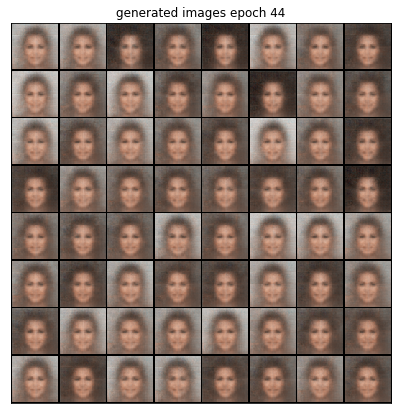

In [24]:
plot_images_grid(net.sample(64, device), title='generated images epoch 44')

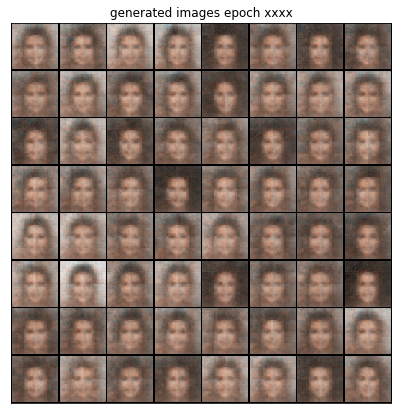

In [ ]:
plot_images_grid(net.sample(64, device), title='generated images epoch xxxx')

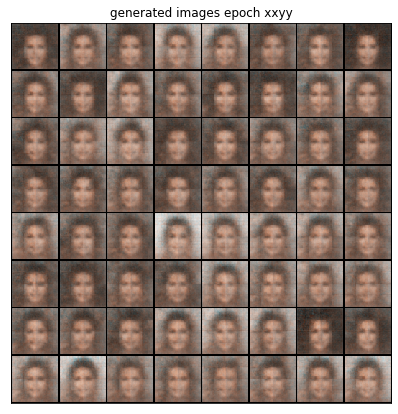

In [ ]:
plot_images_grid(net.sample(64, device), title='generated images epoch xxyy')